from:

https://www.kaggle.com/code/carlolepelaars/bidirectional-lstm-for-audio-labeling-with-keras/notebook

In [194]:
# Dependencies
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Machine Learning
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, CuDNNLSTM, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import tensorflow_addons as tfa

# Path specifications
KAGGLE_DIR = '../input/'
train_curated_path = KAGGLE_DIR + 'train_curated/'
test_path = KAGGLE_DIR + 'test/'

# Set seed for reproducability
seed = 1234
np.random.seed(seed)
# tf.set_random_seed(seed)

# Preprocessing

In [2]:
n_classes = 2

def split_and_label(rows_labels, n_classes):
    '''
    Retrieves a list of all the relevant classes. This is necessary due to 
    the multi-labeling of the initial csv file.
    '''
    row_labels_list = []
    for row in rows_labels:
        row_labels = row.split(',')
        
        labels_array = np.zeros((n_classes))
        for label in row_labels:
            index = label_mapping[label]
            labels_array[index] = 1
        row_labels_list.append(labels_array)
    return row_labels_list

In [3]:
df = pd.read_csv(KAGGLE_DIR + 'smit-tgt-2023/data/train.csv')
test_df = pd.read_csv(KAGGLE_DIR + 'smit-tgt-2023/data/test.csv')

In [266]:
# Preprocessing parameters
sr = 117200 # Sampling rate
duration = 117200 // 300
hop_length = 347//9 # to make time steps 128
fmin = 20
fmax = sr // 2
n_mels = 64
n_fft = n_mels * 20
samples = sr * duration

In [267]:
def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
#     spectrogram = librosa.feature.melspectrogram(y=audio, 
#                                                  sr=sr,
#                                                  n_mels=n_mels,
#                                                  hop_length=hop_length,
#                                                  n_fft=n_fft,
#                                                  fmin=fmin,
#                                                  fmax=fmax)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    return librosa.power_to_db(spectrogram).astype(np.float32)

In [268]:
sample = np.nan_to_num(df.iloc[0, :-1].values)
audio_to_melspectrogram(sample).shape

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1280 is too large for input signal of length=300
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"


(64, 8)

In [255]:
def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

def df_to_mel(df, test=False):
    X = []
    for _,row in tqdm_notebook(df.iterrows()):
        if test:
            x = audio_to_melspectrogram(np.nan_to_num(row.values))
        else:
            x = audio_to_melspectrogram(np.nan_to_num(row[:-1].values))
        X.append(x.transpose())
    return X

In [269]:
# Preprocess dataset and create validation sets
X = df_to_mel(df)
X = normalize_dataset(X)
Y = df['label'].values
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

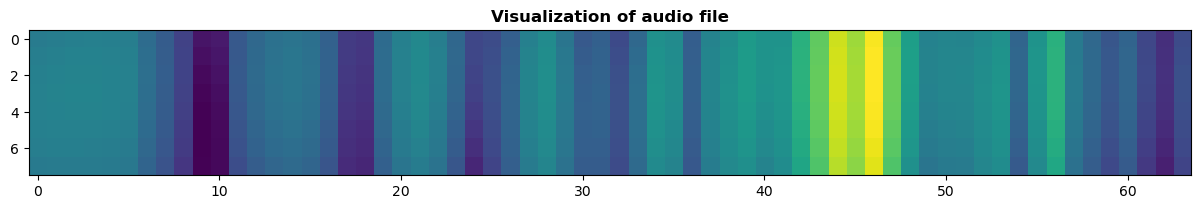

In [270]:
# Visualize an melspectogram example
plt.figure(figsize=(15,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(X[0]);

# Modeling

In [10]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [282]:
# Neural network model
input_shape = (X[0].shape[0], X[0].shape[1])
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)
n_classes = 1

f1 = tfa.metrics.F1Score(num_classes=1, average=None)

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True), input_shape=input_shape))
model.add(Attention(X[0].shape[0]))
model.add(Dropout(0.2))
model.add(Dense(400))
model.add(ELU())
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc', f1])

In [283]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [284]:
# Train model
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
hist = model.fit(np.array(x_train),
          y_train,
          batch_size=512,
          epochs=500,
          validation_data=(np.array(x_val), y_val),
          callbacks = [es],
          class_weight=class_weights)

Epoch 1/500
6/6 [==============================] - 2s 105ms/step - loss: 1.1457 - acc: 0.7524 - f1_score: 0.2937 - val_loss: 0.1792 - val_acc: 0.9407 - val_f1_score: 0.3115
Epoch 2/500
6/6 [==============================] - 0s 19ms/step - loss: 0.2118 - acc: 0.9149 - f1_score: 0.2937 - val_loss: 0.1486 - val_acc: 0.9460 - val_f1_score: 0.3115
Epoch 3/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1455 - acc: 0.9364 - f1_score: 0.2937 - val_loss: 0.1242 - val_acc: 0.9539 - val_f1_score: 0.3115
Epoch 4/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1309 - acc: 0.9479 - f1_score: 0.2937 - val_loss: 0.2722 - val_acc: 0.9078 - val_f1_score: 0.3115
Epoch 5/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1131 - acc: 0.9469 - f1_score: 0.2937 - val_loss: 0.1122 - val_acc: 0.9618 - val_f1_score: 0.3115
Epoch 6/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0831 - acc: 0.9627 - f1_score: 0.2937 - val_loss: 0.0988 - val_ac

# Evaluation 

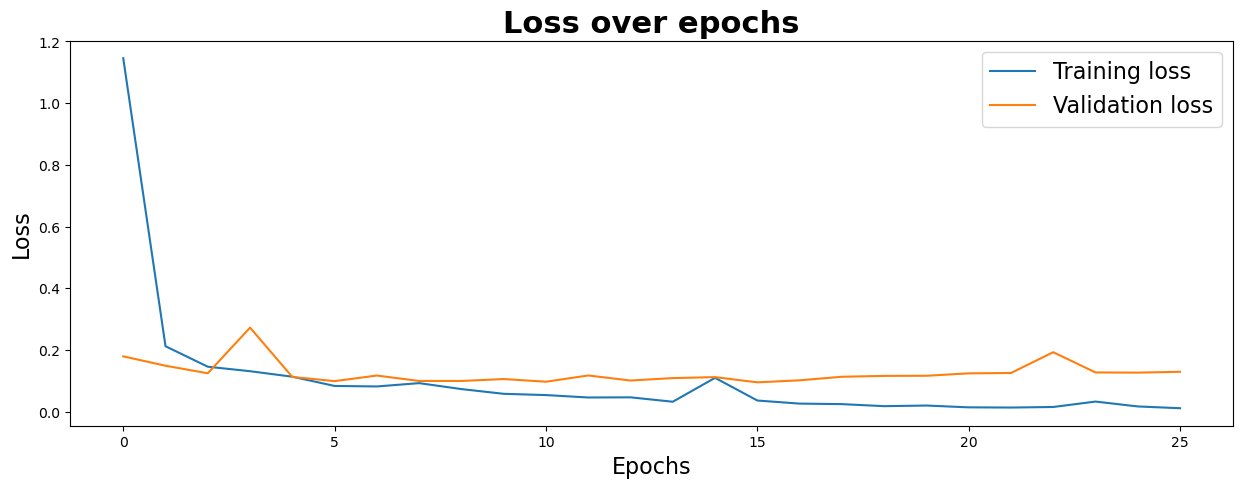

In [285]:
# Visualize loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']
stopped_epoch = es.stopped_epoch
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

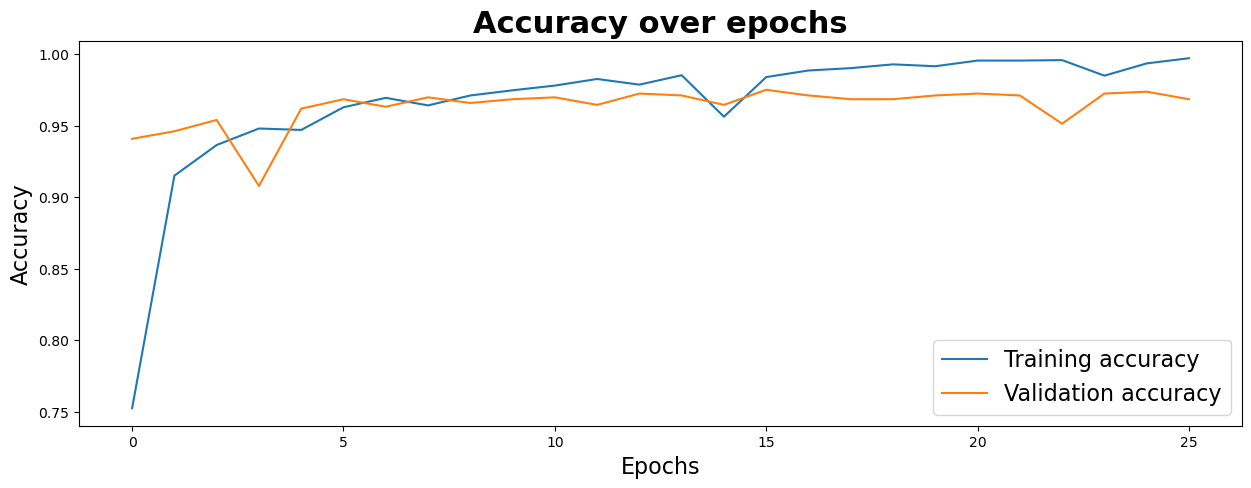

In [286]:
# Visualize Accuracy
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

F1

In [287]:
y_val_pred = model.predict(np.array(x_val))
# y_val_pred = np.where(y_val_pred[:, 0] > 0.5, 0, 1)

24/24 [==============================] - 0s 3ms/step


In [288]:
f1 = tfa.metrics.F1Score(num_classes=1, average='weighted')

f1.update_state(y_val[:, None], y_val_pred)
f1.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.3114572>

# Submit

In [289]:
X_s = df_to_mel(test_df, test=True)
X_s = normalize_dataset(X_s)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [290]:
submit_preds = model.predict(np.array(X_s))
submit_preds = np.where(submit_preds[:, 0] < 0.5, 0, 1)

15/15 [==============================] - 0s 2ms/step


In [291]:
submit_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/submission_sample.csv')
submit_df['label'] = submit_preds
submit_df.to_csv('./b_lstm.csv', index=False)